## Gaussian Mixture Models for TIMIT

+ ###### Authors: Dirk Van Compernolle
+ ###### History:  04/2022, 17/03/2023, 05/03/2024
+ ###### Requires: pyspch v0.7 / 0.8  

Content:
- Training of GMMs for all phonemes
- Frame CLassification
- Applying the models for utterance analysis


In [1]:
####################################################################################
### RUNNING THIS CELL FIRST ##########
### will suppresses warnings on memory leaks, deprecation warnings and future warnings 
### It is brute force .  
### Best is not to run it when you want to debug code or new installations
import os, warnings 
os.environ["OMP_NUM_THREADS"] = '2'  
warnings.filterwarnings("ignore")
####################################################################################

In [2]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import requests
import importlib
import urllib.request
import pickle
import gzip

from sklearn import metrics as skmetrics 
from sklearn.neural_network import MLPClassifier
from IPython.display import display, HTML, Audio

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)
logging.basicConfig(level=logging.INFO)

# print and plot
mpl.rcParams['figure.figsize'] = [7.,7.]
mpl.rcParams['font.size'] = 11
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]

# pyspch
import pyspch
from pyspch.stats import GMM
import pyspch.core as Spch

# 
from pyspch.core.utils_clf import train_GMM, train_MLP, test_clf
from pyspch.core.utils_timit import load_timit_data, print_dataset_statistics, select_subset

# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

## 1.  Get TIMIT Data and do Feature Extraction

#### TIMIT database & Feature Extraction
In the next cell we load preprocessed features for the TIMIT database.   
Three types of features are available on disk:   
- MFCC13: mel frequency cepstral coefficients   
- MEL24:  mel filterbank (low resolution)   
- MEL80:  mel filterbank
  
We add further processing steps:   
- addition of Delta features  : as it has been found that Delta-Features are greatly beneficial in GMM based speech recognizers
- mean and variance normalization per sentence : a standard procedure to minimize session-to-session veriability

At this point all data is stored sequentially sentence-by-sentence.
For our classification experiments (main purpose in this notebook) we restructure the data
as a long list of frames(feature vectors) with a synchronized list of labels.
The classes (set of all labels) are 41 phonetic symbols, i.e. the CMU-39 set + silence + closure.    
The labels were obtained from phonetic segmentations that come with the TIMIT database.

In [77]:
def extract_Xy(data):
    X = data.get_features_as_numpy()
    y = data.get_labels_as_numpy()
    return(X,y)
#
alphabet = 'timit41'
timit41 = pyspch.timit.get_timit_alphabet('timit41')
ftrs = "mel80"  # "mfcc13", "mel24" or "mel80" are available
modify_feature_args = {"Norm":"meanvar","Deltas":"delta","n_cep":24}
#
data = load_timit_data(corpus="train",ftrs=ftrs,alphabet=alphabet)
data.modify_features(modify_feature_args)
X_timit_train, y_timit_train = extract_Xy(data)
#
data = load_timit_data(corpus="test",ftrs=ftrs,alphabet=alphabet)
data.modify_features(modify_feature_args)
X_timit_test, y_timit_test = extract_Xy(data)

## 2. Statistics For the TIMIT Database
These are the numbers for the TRAIN database:   
Number of speakers 600  
Number of samples 1417087   
Minimun number of samples per class:  226266   
Maximum number of samples per class:  1218 

You will note that the data distribution is heavily skewed.
This is normal as some phonemes are way more frequent than others.  
Moreover the average length of a phoneme plays a role as we take each frame as an observation and just look for the corresponding label in the TIMIT transcriptions.
Some phonemes thus have thousands of examples available for training, while others (e.g. 'zh') are only marginally represented, e.g.     
The biggest class is 'sil' with 200k+ samples, the biggest phone classes are 's' and 'ih' with 80k+ samples.  The smallest classes are 'b', 'uh' and 'zh' with less than 5000 samples each.  Detailed counts per subdatabase and class are given below

In [78]:
print_dataset_statistics(y_timit_train,Details=True,txt="Full Train Database")
print_dataset_statistics(y_timit_test,Details=True,txt="Full Test Database")

Statistics for Full Train Database:
Number of classes 41
Number of samples 1417087
Minimun/Maximum number of samples per class:  1218  /  226626
[('aa', 37481), ('ae', 59237), ('ah', 39140), ('ao', 36404), ('aw', 11723), ('ay', 34376), ('b', 3823), ('ch', 7116), ('cl', 137933), ('d', 8158), ('dh', 10640), ('eh', 35133), ('er', 51761), ('ey', 28955), ('f', 22828), ('g', 6031), ('hh', 14142), ('ih', 84270), ('iy', 62901), ('jh', 7063), ('k', 25064), ('l', 43515), ('m', 24859), ('n', 46996), ('ng', 8513), ('ow', 26853), ('oy', 11024), ('p', 11482), ('r', 39609), ('s', 84491), ('sh', 25828), ('sil', 226626), ('t', 28720), ('th', 6862), ('uh', 4077), ('uw', 26444), ('v', 12033), ('w', 20946), ('y', 11322), ('z', 31490), ('zh', 1218)]
Statistics for Full Test Database:
Number of classes 41
Number of samples 517845
Minimun/Maximum number of samples per class:  643  /  81852
[('aa', 14133), ('ae', 21072), ('ah', 14948), ('ao', 14233), ('aw', 3751), ('ay', 12613), ('b', 1562), ('ch', 2244), ('c

## Exercise 1:  Use the vow6-database

##### Downsampling and data selection
For most simple experiments in this notebook we will downsample the full database (typically with a factor 10).   
For some experiments we also work with a subset of phonemes only.

#### 1.1 Do the Reference Experiment

In this experiment we perform vowel recognition from frame data  
The experiment is easy in the sense that the used vowels are rather well distinguishable.   
The experiment is hard because you base your prediction on a single frame positioned well inside but also at the boundaries of a vowel. 

We have entered quite reasonable default values in the next cell:
- use of static and dynamic MFCCs (26D)
- 8 mixtures in the GMM per class
- 4 iterations for the GMM training (the KMeans initialization routine does almost all the work, so little will be gained from iterating)
- priors are used as derived from the training set (set the priors variable to 'training' or 'uniform')
- with these default settings you should achieve an accuracy of approximately 68%  (if you don't get this result, there is probably something wrong in your setup !!)

In [79]:
vow6=['iy','aa','uw','ih','eh','er']
plosives=['p','t','k','b','d','g']
timit41 = pyspch.timit.get_timit_alphabet('timit41')
#
def gmm_experiment(X_train,y_train,X_test,y_test,ng=1,Deltas=True,nftrs="all",priors='training',Verbose=False):
    kwargs =dict(verbose=0,verbose_interval=1,init_params='kmeans') 
    dim = X_train.shape[1]//2
    if nftrs == "all":     nftrs = dim
    elif nftrs > dim: nftrs = dim
    if Deltas:
        ftr_range = np.r_[0:nftrs,dim:dim+nftrs]
    else:
        ftr_range = np.r_[0:nftrs]
    X1 = X_train[:,ftr_range]
    X2 = X_test[:,ftr_range]
    clf_GMM,acc_train = train_GMM(X1, y_train,  classes=classes, n_components=ng, max_iter=4,Verbose=Verbose,**kwargs)
    acc_test,cm = test_clf(clf_GMM,X2, y_test,priors=priors,Verbose=Verbose)
    return(acc_train,acc_test,cm)

Statistics for TRAIN:
Number of classes 6
Number of samples 297990
Minimun/Maximum number of samples per class:  26444  /  84270
[('aa', 37481), ('eh', 35133), ('er', 51761), ('ih', 84270), ('iy', 62901), ('uw', 26444)]
Statistics for TEST:
Number of classes 6
Number of samples 108802
Minimun/Maximum number of samples per class:  7962  /  28815
[('aa', 14133), ('eh', 12793), ('er', 21134), ('ih', 28815), ('iy', 23965), ('uw', 7962)]
Training Set:  Accuracy = 67.51%
Training Set:  LL(per sample) = -30.82
Training Set:  BIC = 18399838.79
Accuracy = 67.76%
Accuracy: TRAIN= 67.51%, TEST= 67.76%


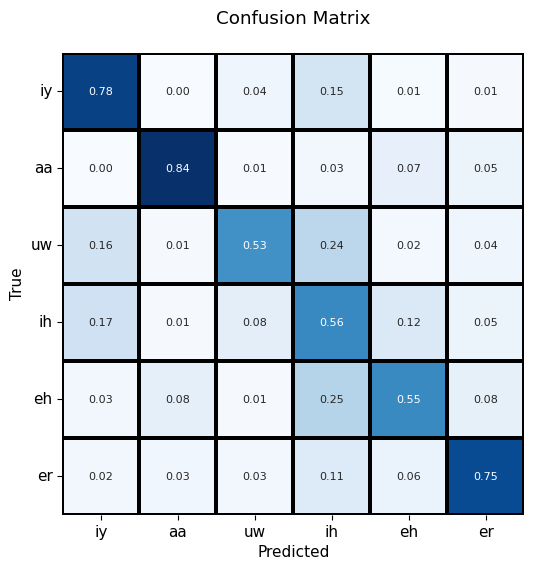

In [80]:
classes=vow6
X_train, y_train = select_subset(X_timit_train,y_timit_train,labels=classes)
X_test, y_test = select_subset(X_timit_test,y_timit_test,labels=classes)
print_dataset_statistics(y_train,Details=True,txt="TRAIN")
print_dataset_statistics(y_test,Details=True,txt="TEST")
#
priors = 'training'       # makes that 'trained' priors are used in classifier
n_components = 8          # 8 is a reasonable value
max_iter = 4              # for this problem a handful of iterations will be sufficient
######################
# you can modify other training settings by using this **kwargs{}
#  kwargs = dict(verbose=2,verbose_interval=1)   will print loglik-change (per sample) per iteration
#  kwargs = dict(init_params='random')           will change initialization to random instead of KMeans  (more convergence effort is needed)
#  kwargs = dict(reg_cover=1.e-6,tol=1.e-3)      are some other parameters controlling regularization and a stopping criterion for training
#
kwargs =dict(verbose=0,verbose_interval=1,init_params='kmeans')          
################   
acc_train, acc_test, cm = gmm_experiment(X_train,y_train,X_test,y_test,ng=8,nftrs=13,Verbose=True)
#
#clf_GMM,_ = train_GMM(X_train, y_train,  classes=classes, n_components=n_components, max_iter=max_iter,Verbose=True,**kwargs)
#acc_test,cm = test_clf(clf_GMM, X_test, y_test,priors=priors)
print("Accuracy: TRAIN= %.2f%%, TEST= %.2f%%" %(acc_train,acc_test))
Spch.plot_confusion_matrix(cm,labels=classes,norm=True,figsize=(6,6),annot_kws={'fontsize':8});

### 1.2  EFFECT OF MODEL SIZE

For speedup reasons we run the next set of experiments on 10% of the TIMIT data.
We want to observe following aspects:
- impact of number of Gaussians (**ngaus**)
- impact of number of features (**nftrs**) (similar to the experiments in timit-1.ipynb)
- impact of augmenting the feature vectors with so-called Delta Features (**Deltas**)


##### QUESTIONS:
- In a number of settings you get a higher accuracy on test set than on training set.  Identify them.
  + Should I believe these data points or should I throw them away ?
  + This is more likely to happen with small models trained on small amounts of data (?)
- With too many free parameters in a machine learning system, you will be overtraining on the train data and performance on the test set can be much worse than predicted from the train data.  Indentify these situations here and formulate general conclusions on optimal model size.
- Quantify (as generally as possible) the effect of using Deltas on performance


In [83]:
# modify the 'downsample' factor to control how much data you use for the following experiments
# downsample = 10 ==> use 10% of the data 
# we set a cap on the minimum number of examples per class to avoid training issues
#
classes = vow6
downsample = 10
mincount = 256
X_train, y_train = select_subset(X_timit_train,y_timit_train,labels=classes,
                           downsample=downsample,mincount=mincount)

X_test, y_test = select_subset(X_timit_test,y_timit_test,labels=classes,
                           downsample=downsample,mincount=mincount)
#
# set here the range of parameters that you which to explore
#  ng: number of gaussians
ng_exp = [1,4,16,64]
Deltas_exp = [False,True]
nftrs_exp = [2,4,8,12,16]
results = []
for Deltas in Deltas_exp:
  for ng in  ng_exp:
      for nftrs in nftrs_exp:
        print("exp[nftrs,Deltas,ngauss]",nftrs,Deltas,ng)
        acc_train, acc_test,_ = gmm_experiment(X_train,y_train,X_test,y_test,ng=ng,nftrs=nftrs,Deltas=Deltas)
        results.append([Deltas,nftrs,ng,'TRAIN',acc_train])
        results.append([Deltas,nftrs,ng,'TEST',acc_test])
        results_df = pd.DataFrame(results,columns=['Deltas','nftrs','ngauss','train/test','accuracy'])
results_df

exp[nftrs,Deltas,ngauss] 2 False 1
exp[nftrs,Deltas,ngauss] 4 False 1
exp[nftrs,Deltas,ngauss] 8 False 1
exp[nftrs,Deltas,ngauss] 13 False 1
exp[nftrs,Deltas,ngauss] 16 False 1
exp[nftrs,Deltas,ngauss] 24 False 1
exp[nftrs,Deltas,ngauss] 2 False 4
exp[nftrs,Deltas,ngauss] 4 False 4
exp[nftrs,Deltas,ngauss] 8 False 4
exp[nftrs,Deltas,ngauss] 13 False 4
exp[nftrs,Deltas,ngauss] 16 False 4
exp[nftrs,Deltas,ngauss] 24 False 4
exp[nftrs,Deltas,ngauss] 2 False 16
exp[nftrs,Deltas,ngauss] 4 False 16
exp[nftrs,Deltas,ngauss] 8 False 16
exp[nftrs,Deltas,ngauss] 13 False 16
exp[nftrs,Deltas,ngauss] 16 False 16
exp[nftrs,Deltas,ngauss] 24 False 16
exp[nftrs,Deltas,ngauss] 2 False 64
exp[nftrs,Deltas,ngauss] 4 False 64
exp[nftrs,Deltas,ngauss] 8 False 64
exp[nftrs,Deltas,ngauss] 13 False 64
exp[nftrs,Deltas,ngauss] 16 False 64
exp[nftrs,Deltas,ngauss] 24 False 64
exp[nftrs,Deltas,ngauss] 2 True 1
exp[nftrs,Deltas,ngauss] 4 True 1
exp[nftrs,Deltas,ngauss] 8 True 1
exp[nftrs,Deltas,ngauss] 13 True 1

,Deltas,nftrs,ngauss,train/test,accuracy
0,False,2,1,TRAIN,48.639399
1,False,2,1,TEST,49.816244
2,False,4,1,TRAIN,55.353488
3,False,4,1,TEST,57.478868
4,False,8,1,TRAIN,59.494011
...,...,...,...,...,...
91,True,13,64,TEST,70.066152
92,True,16,64,TRAIN,77.659967
93,True,16,64,TEST,70.194781
94,True,24,64,TRAIN,78.851122


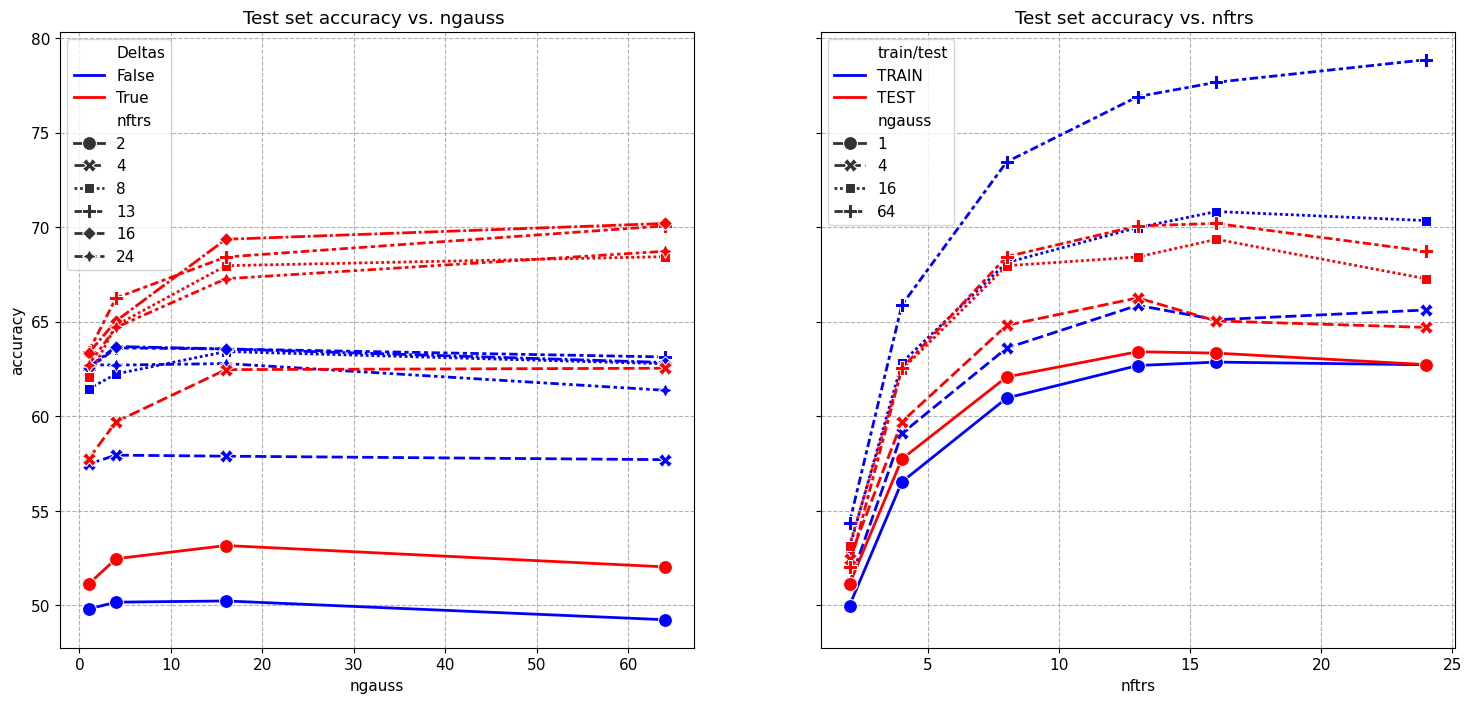

In [84]:
colors=['b','r','g','k','c','m','y']
cmap = sns.color_palette(colors)
sns.set_palette(cmap)
kwargs = {'linewidth':2,'markersize':10,'markers':True}
fig,ax = plt.subplots(1,2,figsize=(18,8),sharey=True)
df = results_df[ results_df['train/test']=='TEST']

sns.lineplot(data=df,x='ngauss',y='accuracy',ax=ax[0],style='nftrs',hue='Deltas',**kwargs);
ax[0].set_title("Test set accuracy vs. ngauss ")
ax[0].grid(linestyle='--')

df = results_df[ results_df['Deltas']==True]
sns.lineplot(data=df,x='nftrs',y='accuracy',style='ngauss',hue='train/test',ax=ax[1],**kwargs);
ax[1].set_title("Test set accuracy vs. nftrs ")
ax[1].grid(linestyle='--');

### 1.3 EFEECT OF DATABASE SIZE
In these experiments we analyze how important the amount of data is.
Important is to observe how amount of data, model detail and overtraining issues are all tied together.

We do similar experiments as above but for different sizes of the database.
We do this by randomly selecting feature vectors to create a subset of the database.
Based on the results from the previous experiments, we FIX following parameters:   
- number of features: 13 MFCC
- use of Deltas: True

In [88]:
classes = vow6
nftrs = 13
Deltas= True
mincount = 256
ds_exp  = [100,20,10,5,1] 
ng_exp = [1,4,16,64]

results = []
for ds in ds_exp:
    X_train, y_train = select_subset(X_timit_train,y_timit_train,labels=classes,
                           downsample=ds,mincount=mincount)
    X_test, y_test = select_subset(X_timit_test,y_timit_test,labels=classes,
                           downsample=ds,mincount=mincount)
    
    for ng in  ng_exp:
        print('exp:', ds,ng)
        acc_train, acc_test, _ = gmm_experiment(X_train,y_train,X_test,y_test,ng=ng,nftrs=nftrs,Deltas=Deltas)
        results.append([100./ds,ng,'TRAIN',acc_train])
        results.append([100./ds,ng,'TEST',acc_test])
        results_df = pd.DataFrame(results,columns=['pct_data','ngauss','train/test','accuracy'])
results_df

exp: 100 1
exp: 100 4
exp: 100 16
exp: 100 64
exp: 20 1
exp: 20 4
exp: 20 16
exp: 20 64
exp: 10 1
exp: 10 4
exp: 10 16
exp: 10 64
exp: 5 1
exp: 5 4
exp: 5 16
exp: 5 64
exp: 1 1
exp: 1 4
exp: 1 16
exp: 1 64


,pct_data,ngauss,train/test,accuracy
0,1.0,1,TRAIN,62.856185
1,1.0,1,TEST,60.278305
2,1.0,4,TRAIN,67.515924
3,1.0,4,TEST,62.049336
4,1.0,16,TRAIN,81.394569
5,1.0,16,TEST,59.898798
6,1.0,64,TRAIN,93.362387
7,1.0,64,TEST,54.775459
8,5.0,1,TRAIN,62.506710
9,5.0,1,TEST,62.979974


Text(0.5, 0.98, 'Effect of Database size and #of Gaussians')

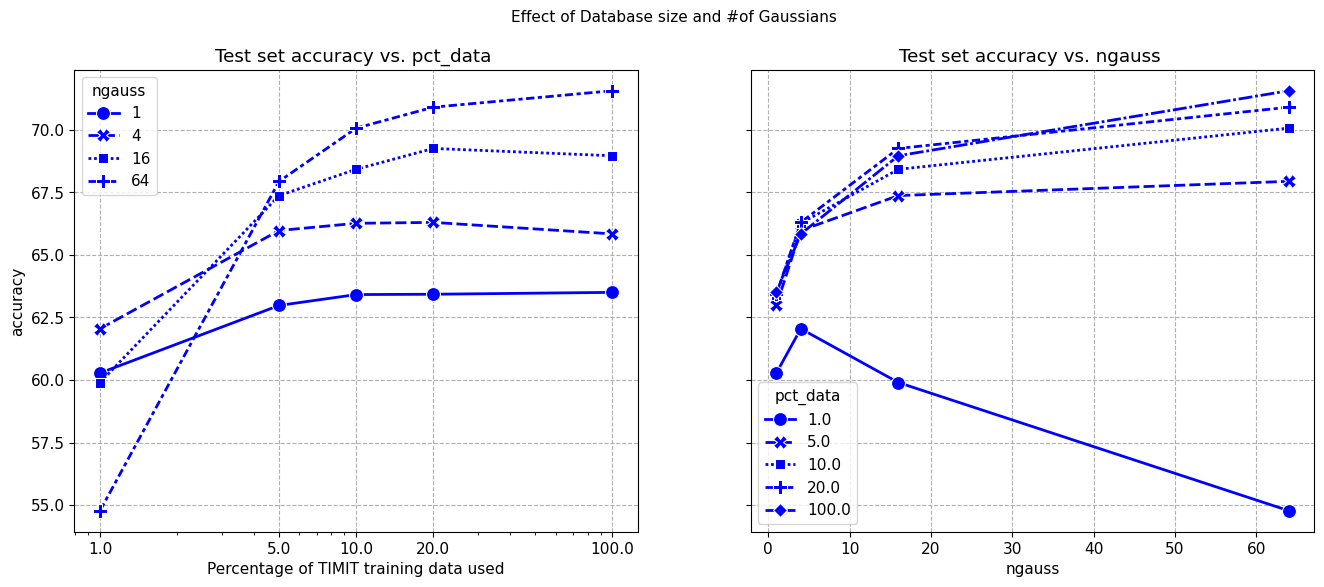

In [89]:
colors=['r','g','b','k','c','m','y']
cmap = sns.color_palette(colors)
sns.set_palette(cmap)
kwargs = {'linewidth':2,'markersize':10,'markers':True}
fig,ax = plt.subplots(1,2,figsize=(16,6),sharey=True)
df = results_df[ results_df['train/test']=='TEST']
#cat_ng = map(str,df['ngauss'].tolist()) # make it categorical for nicer plots
#cat_pct = map(str,df['pct_data'].tolist()) 

sns.lineplot(data=df,x='pct_data',y='accuracy',ax=ax[0],style='ngauss',color='b',**kwargs);
#sns.lineplot(data=df,x='pct_data',y='accuracy',ax=ax[0],style='ngauss',hue='ngauss',**kwargs);
ax[0].set_title("Test set accuracy vs. pct_data ")
ax[0].grid(linestyle='--')
ax[0].set_xscale("log")
ax[0].set_xlabel("Percentage of TIMIT training data used")
pct_list = results_df["pct_data"].unique().tolist()
ax[0].set_xticks(pct_list)
ax[0].set_xticklabels([str(p) for p in pct_list])
hues = map(str,df['ngauss'].tolist())
sns.lineplot(data=df,x='ngauss',y='accuracy',style='pct_data',ax=ax[1],color='b',**kwargs);
ax[1].set_title("Test set accuracy vs. ngauss ")
ax[1].grid(linestyle='--');

fig.suptitle("Effect of Database size and #of Gaussians")

### Questions

- What is the clearest example of overtraining in the above experiments ? Explain.
- What is the clearest example of undertraining in the above experiments ? Explain.   
- In the above experiment, you used maximum 20% of the TIMIT database.  Can you expect still better results if you will use the full database?  Will you see improvements for all models ?
- True or False: "There is little to be gained from using more than 10% of the data"
  

### Exercise 2: Experiments with all phonemes

We are now doing some similar experiments with all phonemes.
For experiment's sake we are using 10% of the database.
We have precomputed training/test results for variable feature sets (with and without Delta's)  and variable number of Gaussians.  This is shown in the table below
Small random deviations in performance results are possible due to hardware, random number initializations, ... 

#### QUESTIONS
1. You see a fabulous increase (for train accuracy) when going from 16 to 64 Gaussians in the table
   - How do you explain this ?
   - Do you expect the same spectacular improvement when evaluating on the independent test set ?
   - Could your conclusions be different if you were to use the FULL TIMIT data set for training ?
  
Note: We obtained 56% frame accuracy when training a 64 mixture on the full timit database.

In [29]:
res1 =  [ [False,1,43.8,42.8], [False,4,45.4,44.1] , [False,16,48.1,44.9] , [False,64,53.9,np.NaN] , [True,1,47.2,46.3], [True,4,51.1,50.0], [True,16,56.7,52.5], [True,64,67.0,np.NaN] ]
res1_df = pd.DataFrame(res1,columns=['Deltas','ng','Train_Acc','Test_Acc'])
res1_df

,Deltas,ng,Train_Acc,Test_Acc
0,False,1,43.8,42.8
1,False,4,45.4,44.1
2,False,16,48.1,44.9
3,False,64,53.9,NaN
4,True,1,47.2,46.3
5,True,4,51.1,50.0
6,True,16,56.7,52.5
7,True,64,67.0,NaN


#### QUESTIONS
Now run an additional experiment (cell below) while using 8 Gaussians and have a look at the confusion matrix.
   
- Confusable pairs ?
    + Which are the most confusable pairs in the confusion matrix ?   
    + Do you understand why they are confusable ?
    + Look at the pair (s,z).  It's not surprising that these are confusable.  What is remarkable, however, if you look in detail ?
- If you change the priors from 'training' (i.e. trained priors) to 'uniform' (all phonemes equally probable) what will happen ?   
    + the gobal error rate will INCREASE / DECREASE ?   
    + the error rate on the worst performing phoneme will INCREASE / DECREASE ?   
    + the error rate on the least frequent phoneme will INCREASE / DECREASE ?

In [36]:
classes = timit41
downsample = 10
mincount = 256
X_train, y_train = select_subset(X_timit_train,y_timit_train,labels=classes,
                           downsample=downsample,mincount=mincount)

X_test, y_test = select_subset(X_timit_test,y_timit_test,labels=classes,
                           downsample=downsample,mincount=mincount)
#
# set here the range of parameters that you which to explore
#  ng: number of gaussians
nftrs=13
ng_exp = [8]
Deltas_exp = [True]
results = []
for Deltas in Deltas_exp:
    for ng in  ng_exp:
        print("exp[nftrs,Deltas,ngauss]",nftrs,Deltas,ng)
        acc_train, acc_test, cm = gmm_experiment(X_train,y_train,X_test,y_test,ng=ng,nftrs=nftrs,Deltas=Deltas)
        results.append([Deltas,ng,'TRAIN',acc_train])
        results.append([Deltas,ng,'TEST',acc_test])
        results_df = pd.DataFrame(results,columns=['Deltas','ngauss','train/test','accuracy'])
print(results_df)

exp[nftrs,Deltas,ngauss] 13 True 8
   Deltas  ngauss train/test   accuracy
0    True       8      TRAIN  53.819973
1    True       8       TEST  51.278531


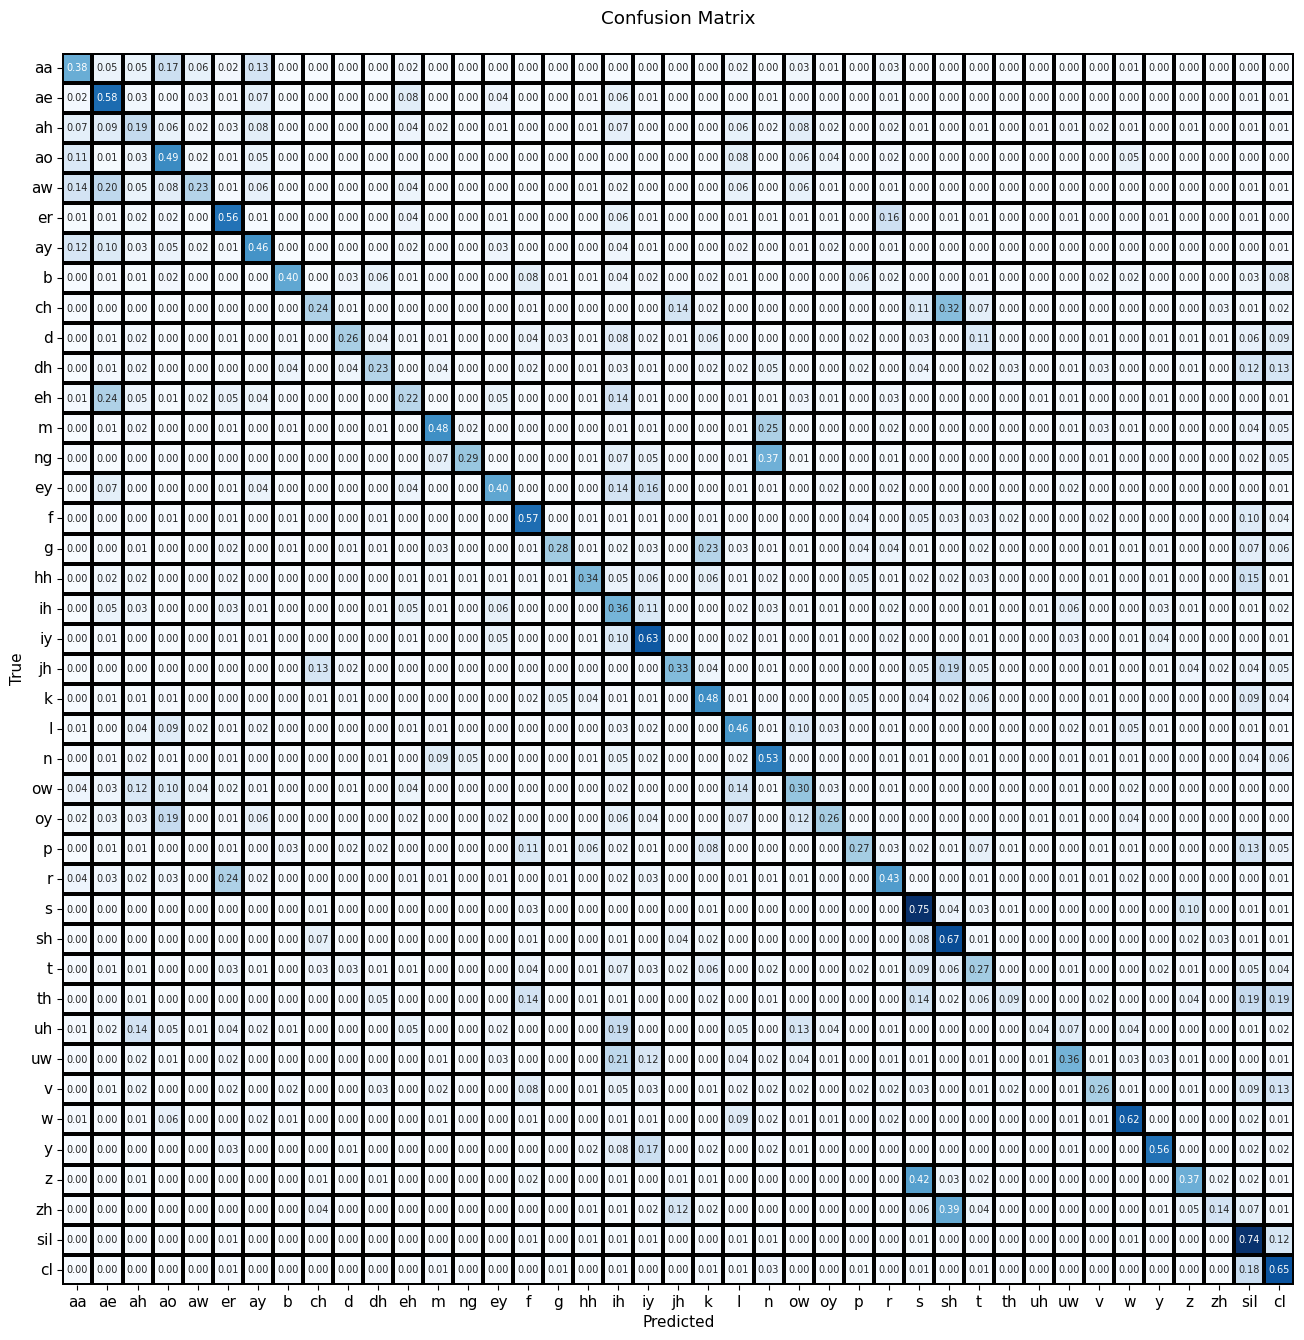

In [37]:
Spch.plot_confusion_matrix(cm,labels=classes,norm=True,figsize=(16,16),annot_kws={'fontsize':7});

## Exercise 3.  Training an MLP Classifier

#### PRELIMINARY NOTE
Training Neural Nets requires computer power.  The implementation here is not intended for large training examples or complex models as it is CPU-only.  We use the sklearn toolkit here for its similarity in API with the GMM models.     
Training single layer networks may go fast, a couple of minutes at most.
Working with 2 and more layers really requires time !
So in practice we are limited to testing nets with 2 hidden layers at most and generally speaking with 10% of the data at most.
This obviously doesn't show the full potential, but notebooks are for quick turnaround and not for heafty training setups.

A few results were saved to the notebook below

In [46]:
classes = vow6 #timit41
downsample = 10
mincount = 256

# ----- extra parameters that can be changed, but might be fine for most tests
max_iter = 500  # maximum number of iterations in the backpropagation algorithm
momentum = 0.9  # only for SGD
early_stopping = True
validation_fraction = 0.1

hidden_layers_test = [(256) , (1024), (512,512) ] # , (512) , (1024), (512,512) , (256,256,256) ]  # network configurations
learning_rate_test = [ 0.005 ]   # initial learning rates for the network training
Deltas_test = [True, False]
ds_test = [ 100, 50, 20, 10]
results = []

for ds in ds_test:
  X_train, y_train = select_subset(X_timit_train,y_timit_train,labels=classes,
                           downsample=ds,mincount=mincount)
  X_test, y_test = select_subset(X_timit_test,y_timit_test,labels=classes,
                           downsample=ds,mincount=mincount)    
  for Deltas in Deltas_exp:
    for hidden_layer_sizes in hidden_layers_test:
        for learning_rate_init in learning_rate_test:
            clf_MLP = MLPClassifier(solver='adam', 
                                    learning_rate_init=learning_rate_init,
                                    hidden_layer_sizes=hidden_layer_sizes,
                                    max_iter=max_iter, alpha=1e-5, random_state=1,
                                    early_stopping=early_stopping,
                                    validation_fraction=validation_fraction)
            clf_MLP.fit(X_train,y_train)

            #print("*** feature_type(dim=%d), hidden layers=%s, lr=%.5f ***" %       (n_dim,hidden_layer_sizes,learning_rate_init))
            y_pred = clf_MLP.predict(X_train)
            train_acc = 100.0*skmetrics.accuracy_score(y_train, y_pred)
            # print('Train Set Accuracy: %.2f%%' % (100.0*train_acc))
            y_pred = clf_MLP.predict(X_test)
            test_acc = 100.0*skmetrics.accuracy_score(y_test, y_pred)
            cmat = skmetrics.confusion_matrix(y_test,y_pred)

            # 3. print and save results            
            print('layers=%s   lr=%.5f     Train Accuracy:%.2f%%    Test Accuracy: %.2f%%' % (hidden_layer_sizes,learning_rate_init,train_acc,test_acc))
            results.append([100./ds,Deltas,nftrs,str(hidden_layer_sizes), 'TRAIN',train_acc])
            results.append([100./ds,Deltas,nftrs,str(hidden_layer_sizes), 'TEST',test_acc])            


results_df = pd.DataFrame(results,columns=['pct_data','Deltas','nftrs','layers','train/test','accuracy'])
print(results_df)

layers=256   lr=0.00500     Train Accuracy:80.96%    Test Accuracy: 62.87%
layers=1024   lr=0.00500     Train Accuracy:80.12%    Test Accuracy: 64.71%
layers=(512, 512)   lr=0.00500     Train Accuracy:89.34%    Test Accuracy: 64.20%
layers=256   lr=0.00500     Train Accuracy:77.14%    Test Accuracy: 68.93%
layers=1024   lr=0.00500     Train Accuracy:75.65%    Test Accuracy: 68.01%
layers=(512, 512)   lr=0.00500     Train Accuracy:84.97%    Test Accuracy: 66.70%
layers=256   lr=0.00500     Train Accuracy:79.01%    Test Accuracy: 70.46%
layers=1024   lr=0.00500     Train Accuracy:78.72%    Test Accuracy: 68.99%
layers=(512, 512)   lr=0.00500     Train Accuracy:79.96%    Test Accuracy: 71.03%
layers=256   lr=0.00500     Train Accuracy:76.02%    Test Accuracy: 72.54%
layers=1024   lr=0.00500     Train Accuracy:75.51%    Test Accuracy: 71.85%
layers=(512, 512)   lr=0.00500     Train Accuracy:79.56%    Test Accuracy: 73.55%
    pct_data  Deltas  nftrs      layers train/test   accuracy
0     

In [50]:
results_df

,pct_data,Deltas,nftrs,layers,train/test,accuracy
0,1.0,True,13,256,TRAIN,80.958766
1,1.0,True,13,256,TEST,62.871600
2,1.0,True,13,1024,TRAIN,80.120684
3,1.0,True,13,1024,TEST,64.705882
4,1.0,True,13,"(512, 512)",TRAIN,89.339591
5,1.0,True,13,"(512, 512)",TEST,64.199873
6,2.0,True,13,256,TRAIN,77.142378
7,2.0,True,13,256,TEST,68.930762
8,2.0,True,13,1024,TRAIN,75.649841
9,2.0,True,13,1024,TEST,68.010517


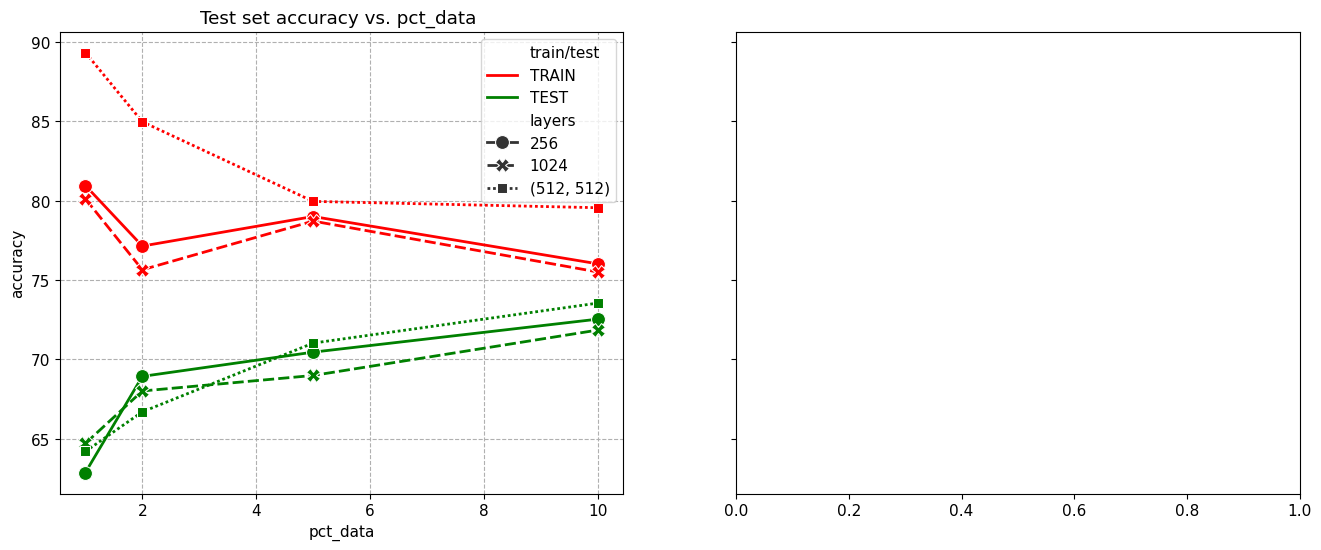

In [49]:
colors=['r','g','b','k','c','m','y']
cmap = sns.color_palette(colors)
sns.set_palette(cmap)
kwargs = {'linewidth':2,'markersize':10,'markers':True}
fig,ax = plt.subplots(1,2,figsize=(16,6),sharey=True)
#df = results_df[ results_df['train/test']=='TEST']

sns.lineplot(data=results_df,x='pct_data',y='accuracy',ax=ax[0],style='layers',hue='train/test',**kwargs);
ax[0].set_title("Test set accuracy vs. pct_data ")
ax[0].grid(linestyle='--')
#hues = map(str,df['ngauss'].tolist())
#sns.lineplot(data=df,x='ngauss',y='accuracy',style='pct_data',ax=ax[1],color='b',**kwargs);
#ax[1].set_title("Test set accuracy vs. ngauss ")
#ax[1].grid(linestyle='--');

## Exercise 4: Using the models in Continuous Speech Recognition

In this part we will use the trained models to compute frame probabilities (likelihoods or posteriors) for an utterance.
Computing these frame probabilities is just a first step towards continuous speech recognition.  
We can evaluate frame recognition rate within a sentence.   
Also we can observe how stable / unstable such observation probabilities are over time.

##### Note on transcriptions and labels
NOTE 1.
One of the labels is 'cl', i.e. closure before a plosive.  These are often present in your transcriptions, e.g.
-  bricks: b r ih cl k s

NOTE 2.
The transcriptions in TIMIT are labels as given by humans listening to very short fragments of an utterance.   Their transcription reflect the sound that they here .  Thus it is NOT a  CANONICAL transcription which is the transcription you find in a dictionary.
As such you may encounter pronunciation variants:
- is: ih s
- is: iy z

##### Questions.
Question 1:
- Select example 2 ("bricks")
- Have a look at the frame probabilites
    + where does the recognizer seems fairly certain
    + assuming  you only have these prob's as your input (i.e. this is what a recognizer gets), what word would you form if you only take into accounts segments of a couple frames that are consistently recognized as the same phone?
    
Question 2:
- Give an example of phonetic confusion that in your opinion will probably not hurt the recognizer when it can use lexical information

In [7]:
# utilities for saving and retrieving models from pickle files
def save_pickle(data,filename):
    picklefile = open(filename, 'wb')
    pickle.dump(data, picklefile),
    picklefile.close()    
def get_pickle(filename):
    picklefile = pyspch.read_fobj(filename)    
    data = pickle.load(picklefile)
    picklefile.close()
    return(data)

# plot utilities
def plot_probs(probs, labels,  fig, iax=2, x0=0.,vmin=None, title="", style="line"):
    '''
    Utility to add selected phone predictors/posteriors ...  to an axis in line or img view 
    '''
    ax = fig.axes[iax]
    # find selected indices from phone labels
    #indx_sel = [labels.index(phn) for phn in selection]
    #probs = probs[:,indx_sel]
    
    ## 
    if style =="img":
        sns.heatmap(probs.T, ax=ax, yticklabels=labels, cmap=cmap_jet2,vmin=vmin,linewidths=1,linecolor='k',cbar_kws={'pad':0.0})
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T, iax=iax, x0=x0, dx=.01, yrange=[0.,1.],color=None)   # defaults to blue for all lines if not specified
        fig.axes[iax].legend(labels, loc='center right', fontsize='x-small') # bbox_to_anchor=(1.00,.5))  # , ncol=15)
    ax.set_title(title)

In [8]:
timit_root='https://homes.esat.kuleuven.be/~spchlab/data/timit/'
classes = timit41
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}

# select a test file for analysis
#################################
example = 2
test_files = ['test/dr1/faks0/si2203',  'test/dr8/fcmh1/si1493', 'test/dr4/fadg0/si1279', 'train/dr1/fcjf0/sx307', 'train/dr1/fdaw0/sx236'] #,'train/dr1/fdml0/si1779']
name = test_files[example]
if name == 'test/dr1/faks0/si2203':    # segment selection "for this dive"
    transcrition = "the reasons for this dive are foolish by now"
    segment_transcription = "for this dive"
    phn_sel = np.array(['sil','cl','d','dh','z','s','f','v','r','er','aa','ay','ah','ao','ih']) #'sil','iy','aa','cl'
    frames=[132,209] # [150,250] # #  [160,185]   # [250,350] # 
elif name ==  'test/dr8/fcmh1/si1493':  # segment selection "by that time perhaps something "
    phn_sel = np.array(['sil','cl','b','dh','t','p','s','m','ay','aa','ae','ah','iy','th'])
    phn_sel = np.array(['sil','cl','b','dh','t','p','ay','aa','ae','ah','eh'])
    frames=[10,65]
elif name == 'test/dr4/fadg0/si1279':  # bricks are an alternative
    transcription = "bricks are an alternative"
    segment_transcription = "bricks"
    phn_sel = np.array(['sil','b','r','ih','cl','k','s','dh','t','iy','ae','eh','ey','z'])
    frames = [10,50]
elif name == 'train/dr1/fcjf0/sx307': # the meeting is now adjourned
    transcription = "the meeting is now adjourned"
    segment_transcription = "the meeting is now"
    phn_sel = np.array(['sil','ih','iy','ey','aw','ay','dh','t','s','f','z','ng','n','m']) 
    frames = [5,80]
elif name == 'train/dr1/fdaw0/sx236': # clear pronunciation is appreciated
    transcription = "clear pronunciation is appreciated"
    segment_transcription = "is appreciated"
    phn_sel = np.array(['sil','cl','ah','aw','ae','eh','ey','ih','iy','uh','b','d','dh','p','t','k','r','l','s','sh','ng','n','m'])
    frames = [160,250]
else:
    phn_sel = phnset
    frames = [0,-1]
#
shift = 0.01
indx_sel = [classes.index(phn) for phn in phn_sel]
frame_sel = slice(frames[0],frames[1])
x0 = (frames[0]+.5)*shift

# audio and feature extraction
example_audio, sample_rate = pyspch.audio.load(timit_root + 'audio/' + name + ".wav")
example_spg = pyspch.sp.feature_extraction(example_audio, sample_rate=sample_rate) #, **setup.feature_args)
example_features = pyspch.sp.feature_extraction(example_audio, **feature_args)
# transcription + word segmentation 
# transcription + word segmentation 
example_txt = pyspch.read_txt(timit_root + 'segmentation/' + name + ".txt")
example_wrd = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".wrd", dt=1/sample_rate)
print(example_txt)    
# get reference segmentation and labels , phone segmentation (+ as index)
example_phn = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".phn", fmt="float32", dt=1/sample_rate,xlat='timit61_timit41')
example_lab = pyspch.seg2lbls(example_phn, n_frames=example_features.shape[1],pad_lbl='sil') 

['0 29082 Bricks are an alternative.']


In [10]:
# Import a model or reuse one of the models that you have trained above
#######################################################################
timit_models = "https://homes.esat.kuleuven.be/~spchlab/data/timit/models/gmm/"
# clf_test = get_pickle("GMM_TIMIT_MINI_D26_G8.pk")   # D26 = 26 dim features, G8 = 8 Gaussians, TIMIT_MINI = training database
clf_test = get_pickle(timit_models+"S41_D26_G64_FULL_1.pkl")   # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
classes = clf_test.classes

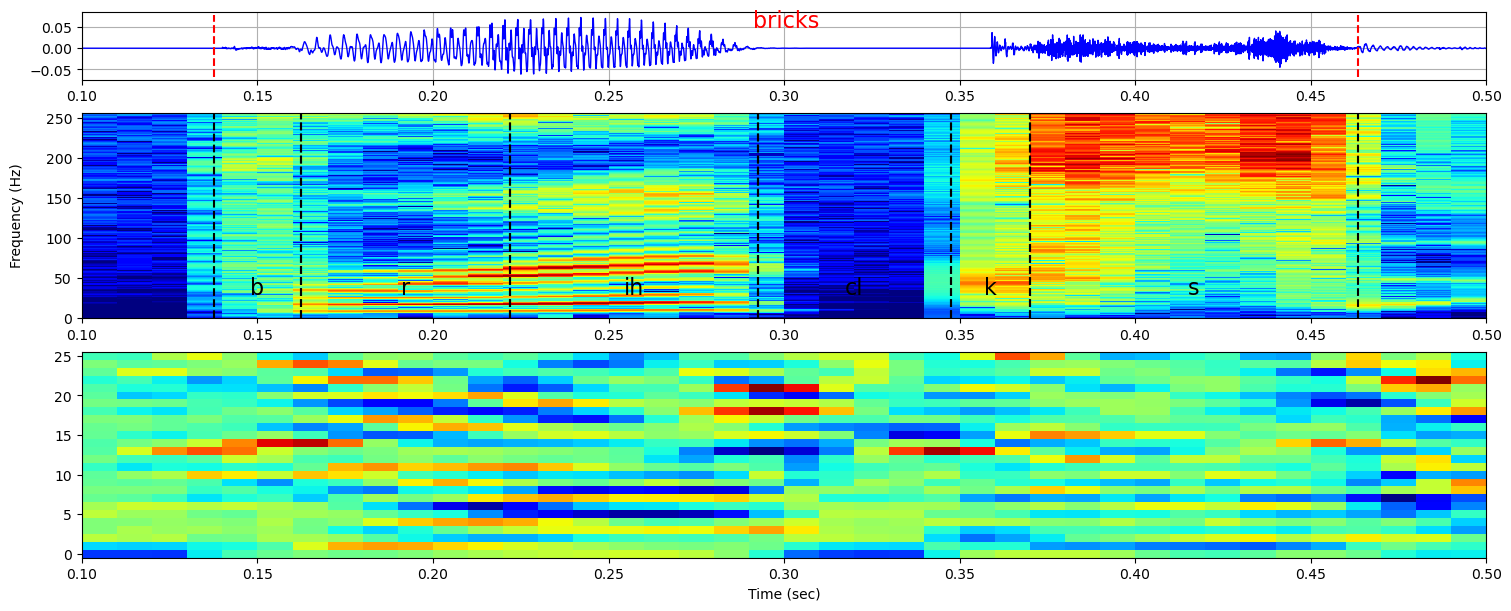

In [11]:
#  SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
#################################
fig = pyspch.display.PlotSpgFtrs(wavdata=example_audio, spgdata=example_spg,dy=1,
                            frames=frames, sample_rate=sample_rate, figsize=(15,6), img_ftrs=[example_features])
fig.add_seg_plot(example_phn, iax=1, ypos=.15, color='k') 
fig.add_seg_plot(example_wrd, iax=0, ypos=.9, color='r') # seg
display(fig)
display(Audio(data=example_audio,rate=sample_rate))

In [12]:
# compute frame posterior probabilities and do frame by frame recognition, compute the frame error rate in the sentence
##########################################################################
postprob_gmm = clf_test.predict_proba(X=example_features.T)
# evaluate frame based recognition wrt. manual segmentations
y_gmm_idx = np.argmax(postprob_gmm, axis=1)
y_gmm_lab = [classes[i] for i in y_gmm_idx]
# alternative
# y_gmm_lab = clf_GMM.predict(X=example_features.T)
y_gmm_seg = pyspch.lbls2seg(y_gmm_lab)
n_corr = np.sum([y_gmm_lab[i] == example_lab[i] for i in range(len(example_lab))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(example_lab)))

Frame Recognition Rate (for full utterance): 60.22 %


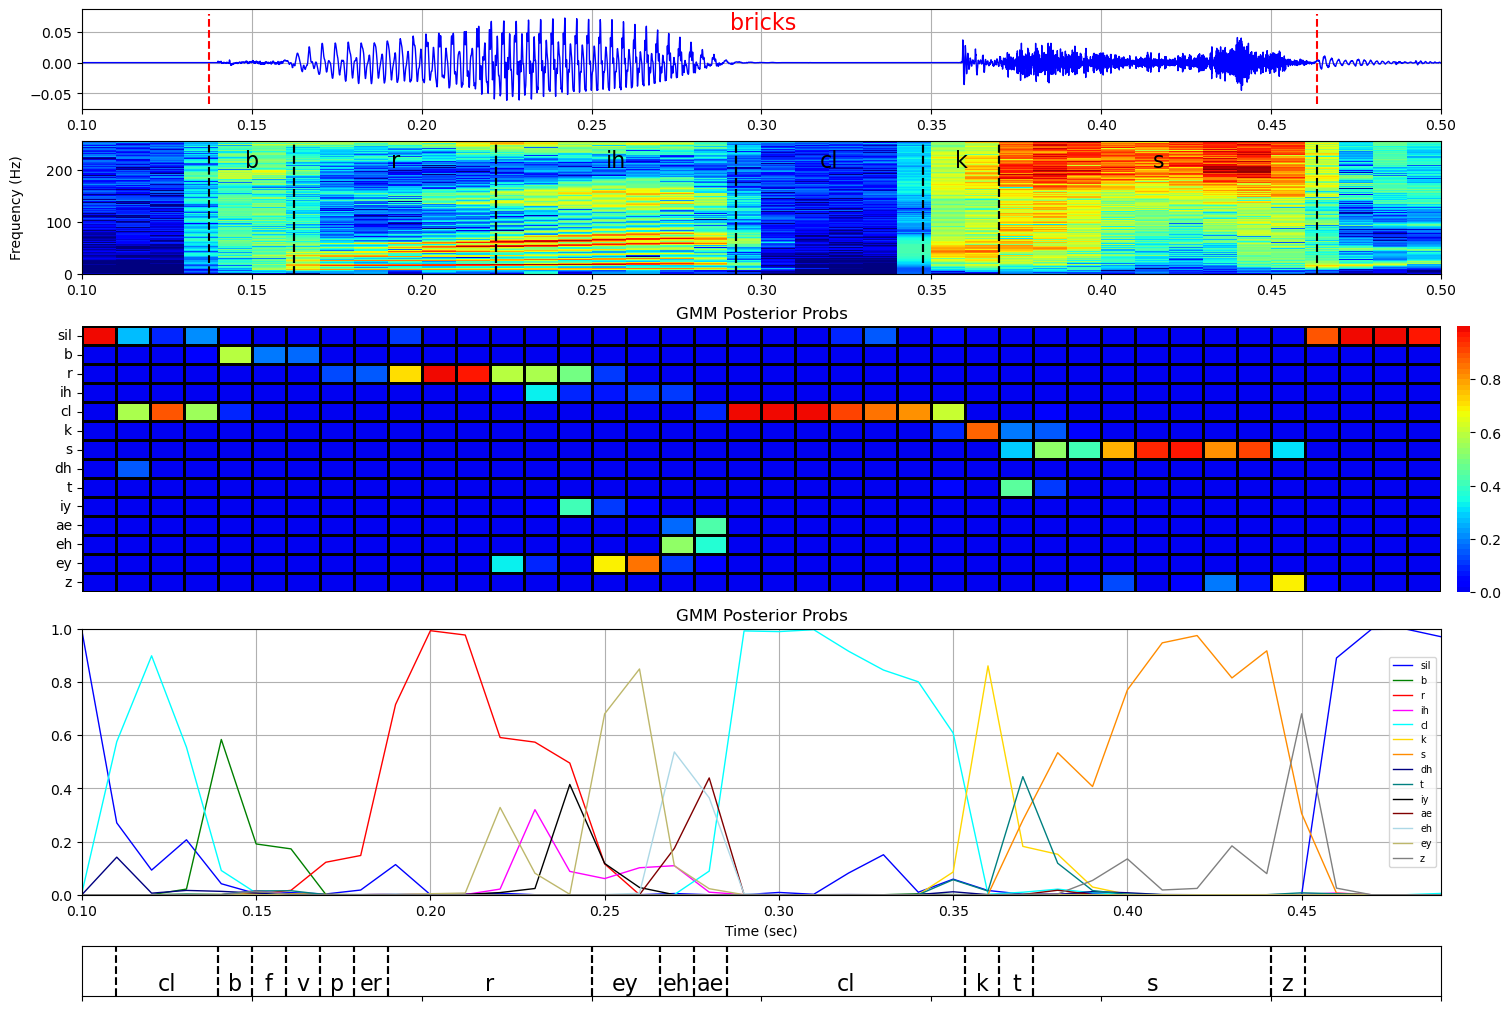

In [13]:
# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=example_audio, spgdata=example_spg,dy=1,row_heights=[1.5,2,4,4,.75],
                                 frames=frames, sample_rate=sample_rate, figsize=(15,10), img_ftrs=[None,None])
fig.add_seg_plot(example_phn, iax=1, ypos=.85, color='k') # seg
fig.add_seg_plot(example_wrd, iax=0, ypos=.9, Lines=True, color='r')

#plot_probs(prob_dnn_sel, phn_sel,fig=fig, iax=0, x0=frames[0]*.01, style="line", title="DNN Posterior Probs") # probs
plot_probs(postprob_gmm[frame_sel,indx_sel], phn_sel,fig=fig, iax=2, x0=frames[0]*.01, style="img", title="GMM Posterior Probs")
plot_probs(postprob_gmm[frame_sel,indx_sel], phn_sel,fig=fig, iax=3, x0=frames[0]*.01, style="line", title="GMM Posterior Probs")

fig.add_seg_plot(y_gmm_seg, iax=4, ypos=.25, Lines=True, color='k') # predicted labels
fig